In [46]:
import numpy as np
import matplotlib.pyplot as plt

class Utils:
    def __init__(self, alpha, beta):
        # parameters of Value Neural Network
        self.W = [0.1] * 6
        self.b_w = [0.1] * 3
        self.H_w = [0.1] * 2
        # parameters of Action Neural Network
        self.Q = [0.1] * 6
        self.b_Q = [0.1] * 3
        self.H_Q = [0.1] * 2
        # define super parameters
#         self.alpha = 1e-9
#         self.beta = 1e-9
        self.alpha = alpha
        self.beta = beta
        self.lamb_w = 0
        self.lamb_Q = 0
        # eligibility trace vector
        self.z_w = [0] * 9
        self.z_Q = [0] * 9
        # simulate stock price
        self.S0 = 100
        self.S = self.S0
        self.avg_reward_track = []
        self.K = 100
        self.su = 1.1
        self.sd = 1 / 1.1
        
        self.avgR = 0
        
    def reset(self):
        self.z_w = [0] * 9
        self.z_Q = [0] * 9
        self.S = self.S0
        self.avgR = 0
        
    # construct value neural network
    def valueNetwork(self, I1, I2):
        # construct hidden layer
        self.H_w[0] = I1 * self.W[0] + I2 * self.W[2] + self.b_w[0]
        self.H_w[1] = I1 * self.W[1] + I2 * self.W[3] + self.b_w[1]
        # construct output layer
        O1 = self.H_w[0] * self.W[4] + self.H_w[1] * self.W[5] + self.b_w[2]
        return O1
    
    # construct action/Policy neural network (pi)
    def actionNetwork(self, I1, I2):
        # construct hidden layer
        self.H_Q[0] = I1 * self.Q[0] + I2 * self.Q[2] + self.b_Q[0]
        self.H_Q[1] = I1 * self.Q[1] + I2 * self.Q[3] + self.b_Q[1]
        # construct output layer
        O1 = self.H_Q[0] * self.Q[4] + self.H_Q[1] * self.Q[5] + self.b_Q[2]
        return O1
    
    # obtain the next stock price with binomial pricing method
    def nextStock(self, S):
        isUp = np.random.rand() >= 0.5
        if isUp:
            S_next = S * self.su
        else:
            S_next = S * self.sd
        return S_next
    
    # define a reward function manually
    def reward(self, C, C_next, S, S_next, act):
        diff = -1 * abs(C_next - C - act * (S_next - S))
        return diff
    
    # calculate call Pricec in terms of stock price
    def callPrice(self, S):
        C = 0.5 * (max(0, S * self.su - self.K)) + 0.5 * (max(0, S * self.sd - self.K))
        return C
    
    def deriveValue(self, I1, I2):
        d_w = [0] * 6
        d_b = [0] * 3
        
        d_w[0] = self.W[4] * I1
        d_w[1] = self.W[5] * I1
        d_w[2] = self.W[4] * I2
        d_w[3] = self.W[5] * I2
        d_w[4] = self.H_w[0]
        d_w[5] = self.H_w[1]
        
        d_b[0] = self.W[4]
        d_b[1] = self.W[5]
        d_b[2] = 1
        return d_w, d_b
   
    def deriveAction(self, I1, I2):
        d_Q = [0] * 6
        d_b = [0] * 3
        temp = 1 / (self.actionNetwork(I1, I2) + 0.01)
        
        d_Q[0] = self.Q[4] * I1 * temp
        d_Q[1] = self.Q[5] * I1 * temp
        d_Q[2] = self.Q[4] * I2 * temp
        d_Q[3] = self.Q[5] * I2 * temp
        d_Q[4] = self.H_Q[0] * temp
        d_Q[5] = self.H_Q[1] * temp
        
        d_b[0] = self.Q[4] * temp
        d_b[1] = self.Q[5] * temp
        d_b[2] = 1 * temp
        return d_Q, d_b

In [47]:
# inherit the class "Utils"
class Model(Utils):
    def __init__(self, alpha, beta):
        super(Model, self).__init__(alpha, beta)
        self.epsilon = 0
    
    def action(self, C, S):
        isGreedy = np.random.rand() >= self.epsilon
        if not isGreedy:
            act = np.random.rand()
        else:
            act = self.actionNetwork(C, S)
        return act
    
    def step(self, S, ind):
        S_next = self.nextStock(S)
        C = self.callPrice(S)
        C_next = self.callPrice(S_next)
        act = self.action(C, S)
        
        R = self.reward(C, C_next, S, S_next, act)
        gamma = R - self.avgR + self.valueNetwork(C_next, S_next) - self.valueNetwork(C, S)
        self.avgR = self.avgR + gamma / ind
        
        d_w, d_b_w = self.deriveValue(C, S)
        d_Q, d_b_Q = self.deriveAction(C, S)
        for i in range(6):
            self.z_w[i] = self.lamb_w * self.z_w[i] + d_w[i]
            self.z_Q[i] = self.lamb_Q * self.z_Q[i] + d_Q[i]
        
        for i in range(3):
            self.z_w[i+6] = self.lamb_w * self.z_w[i+6] + d_b_w[i]
            self.z_Q[i+6] = self.lamb_Q * self.z_Q[i+6] + d_b_Q[i]
            
        for i in range(6):
            self.W[i] = self.W[i] + self.beta * gamma * self.z_w[i]
            self.Q[i] = self.Q[i] + self.alpha * gamma * self.z_Q[i]
        
        for i in range(3):
            self.b_w[i] = self.b_w[i] + self.beta * gamma * self.z_w[i+6]
            self.b_Q[i] = self.b_Q[i] + self.alpha * gamma * self.z_Q[i+6]
        
        return R
    
    def train(self, T):
        reward = 0
        self.reset()
        for i in range(T):
            R = self.step(self.S, i+1)
            self.S = self.nextStock(self.S)
            reward += R
        avgRe = reward/episodes
        self.avg_reward_track.append(avgRe)
        

### Case 1: Time step T=1, the model performs quite well as the reward value converges to near-zero quickly.

In [48]:
# nums = 1000000
# episodes = 5
nums = 1000000
T = 1

alpha = 1e-8
beta = 1e-8
model = Model(alpha, beta)
for i in range(nums):
    if i % (nums/10) == 0:
        print("execute:", i / nums * 100, "%")
    model.train(T)

execute: 0.0 %
execute: 10.0 %
execute: 20.0 %
execute: 30.0 %
execute: 40.0 %
execute: 50.0 %
execute: 60.0 %
execute: 70.0 %
execute: 80.0 %
execute: 90.0 %


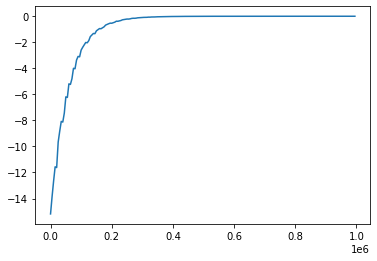

In [49]:
re = model.avg_reward_track
newRe = []
x = []
for i in range(len(re)):
    if i % 5000 == 0:
        newRe.append(re[i])
        x.append(i)

plt.plot(x, newRe)
plt.show()

In [51]:
# reward越接近0，说明模型的结果越好
model.avg_reward_track[-10:]

[-0.0029181677504395154,
 -0.0026538659988410984,
 -0.002652886915575081,
 -0.0026519078476594515,
 -0.002916021674604252,
 -0.002651915053901277,
 -0.002650936001225901,
 -0.0026499569639000242,
 -0.0029138757361213408,
 -0.0029149606572058673]

### Case 2: Time step T=5. We can see the reward function has much higher oscillation and slower convergence compared with the case of T=1. To improve the model, we might deepen our neural network and conduct parameter tuning further.


In [70]:
nums = 2000000
T = 5
alpha = 5e-10
beta = 5e-10
model = Model(alpha, beta)
for i in range(nums):
    if i % (nums/10) == 0:
        print("execute:", i / nums * 100, "%")
    model.train(T)

execute: 0.0 %
execute: 10.0 %
execute: 20.0 %
execute: 30.0 %
execute: 40.0 %
execute: 50.0 %
execute: 60.0 %
execute: 70.0 %
execute: 80.0 %
execute: 90.0 %


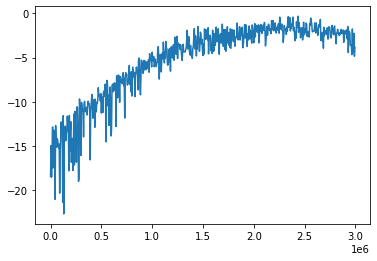

In [61]:
re = model.avg_reward_track
newRe = []
x = []
for i in range(len(re)):
    if i % 5000 == 0:
        newRe.append(re[i])
        x.append(i)

plt.plot(x, newRe)
plt.show()

In [69]:
# The closer reward is to 0, the better the model is
max(model.avg_reward_track)

-0.8515228715708707

In [65]:
model.avg_reward_track[-10:]

[-3.51538650267288,
 -2.0262195508530954,
 -2.2708733156818908,
 -2.0892546115300554,
 -2.1894037602267042,
 -2.9278844662330257,
 -2.216241634959423,
 -3.803458581087638,
 -2.2104027349507356,
 -2.958214662079879]

## Simulate result of delta hedge with black-scholes model 

In [78]:
import numpy as np


class BS_Model():
    def __init__(self):
        # simulate stock price
        self.S0 = 100
        self.S = self.S0
        self.K = 100
        self.su = 1.1
        self.sd = 1 / 1.1
        self.reward_track = []
        
    def reset(self):
        self.S0 = 100
        self.S = self.S0
        self.K = 100
        self.su = 1.1
        self.sd = 1 / 1.1
        self.reward_track = []
        
    # obtain the next stock price with binomial pricing method
    def nextStock(self, S):
        isUp = np.random.rand() >= 0.5
        if isUp:
            S_next = S * self.su
        else:
            S_next = S * self.sd
        return S_next
    
    # calculate call Pricec in terms of stock price
    def callPrice(self, S):
        C = 0.5 * (max(0, S * self.su - self.K)) + 0.5 * (max(0, S * self.sd - self.K))
        return C
    
    def calDelta(self, S):
        Cu = self.callPrice(self.su * S)
        Cd = self.callPrice(self.sd * S)
        delta = (Cu - Cd) / (self.su * S - self.sd * S)
#         print("***", self.su * S, " ", self.sd * S)
#         print("****", Cu, " ", Cd)
#         print("*****", delta)
        return delta
    
    # define a reward function manually
    def reward(self, C, C_next, S, S_next, delta):
        diff = -1 * abs(C_next - C - delta * (S_next - S))
#         print(delta)
        return diff
    
    def step(self, S):
        S_next = self.nextStock(S)
        C = self.callPrice(S)
        C_next = self.callPrice(S_next)
        delta = self.calDelta(S)
        reward = self.reward(C, C_next, S, S_next, delta)
        self.reward_track.append(reward)
#         print("delta: ", round(delta,2), " C: ", round(C,2)," C_next: ", round(C_next,2), " S: ", round(S,2), " S_next: ", round(S_next,2), " reward:", round(reward,2))
        
        
    def train(self, T):
        self.reset()
        for i in range(T):
            self.step(self.S)
            self.S = self.nextStock(self.S)

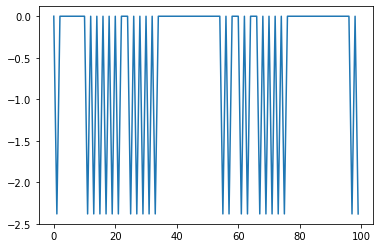

In [83]:
import matplotlib.pyplot as plt
model = BS_Model()

model.train(100)
res = model.reward_track

plt.plot(res)
plt.show()

### Summary of Delta Hedge:
In the reward graph, we can find the reward value is highly volatile, and several points have zero rewards (which is most preferred). 

Those zero-reward points refer to the fully hedged situation where the stock price is very high or low, s.t. delta = 1 or 0. 

From the reward graph, we can see delta hedge doesn’t work out well. We think it may be because the price change is discrete, therefore, delta = dc/dS can’t perfectly fit the change of European call option price along with stock price.
